# Prediction model of RRFs of compounds detected by GC/MS

## 0. Conception

*Which decision are we going to inform?* \
We will assist labs by predicting RRFs detected by GC/MS

*What is our prediction estimand?* \
Input data :  Several molecular and physico-chemical characteristics.
The outcome is continuous : Relative Response Factor

*How can you measure the model's success?* \
The model's success will be mostly assessed with the one having the highest R², lowest test MSE. \

### Loading Libraries

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chemistry
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Scikit-learn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.model_selection import KFold, cross_val_predict
from lightgbm import LGBMRegressor


sns.set(style="whitegrid")

# Hyperparameter tuning
import optuna

## 1. Data acquisition

The excel file was created by manually copying the table from the US FDA CLAP list and the table S1 supplementary data from Yun et al.


In [186]:
df = pd.read_excel('processed_data/RRFML.xlsx')

## 2. Exploratory data analysis

In [187]:
df.describe()


,DBE,MW,BP,logP,Refractive Index,5 µg/mL,10 µg/mL,20 µg/mL
count,92.000000,92.000000,91.000000,92.000000,89.000000,92.000000,92.000000,92.000000
mean,5.309783,303.179348,359.889011,6.055326,1.523247,0.374228,0.406674,0.412489
std,4.100953,160.177748,127.047844,4.117937,0.087404,0.463968,0.484548,0.446450
min,0.000000,102.200000,148.300000,-0.660000,1.289000,0.000000,0.000000,0.000000
25%,2.000000,195.550000,259.400000,3.142500,1.454000,0.030250,0.037250,0.053500
50%,4.000000,285.450000,359.400000,5.355000,1.499000,0.207000,0.287000,0.278000
75%,8.000000,375.600000,435.500000,8.475000,1.585000,0.534000,0.527000,0.608500
max,20.000000,1177.600000,779.000000,23.000000,1.757000,2.551000,2.143000,1.810000


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Code               92 non-null     object 
 1   IUPAC name         92 non-null     object 
 2   CAS #              92 non-null     object 
 3   Empirical Formula  92 non-null     object 
 4   DBE                92 non-null     float64
 5   MW                 92 non-null     float64
 6   BP                 91 non-null     float64
 7   pKa                65 non-null     object 
 8   logP               92 non-null     float64
 9   Refractive Index   89 non-null     float64
 10  5 µg/mL            92 non-null     float64
 11  10 µg/mL           92 non-null     float64
 12  20 µg/mL           92 non-null     float64
dtypes: float64(8), object(5)
memory usage: 9.5+ KB


## 3. Data preprocessing

We will first convert the CAS number of the extractables into Smiles using pubchem library. This is necessary to get molecular descriptors from the RdKit library.

In [189]:
def get_smiles_from_cas(cas):
    """Utility to fetch SMILES via PubChem"""
    try:
        results = pcp.get_compounds(cas, 'name')
        if results:
            return results[0].smiles
    except Exception as e:
        return None
    return None

df['SMILES'] = df['CAS #'].apply(get_smiles_from_cas)


This CAS number '68515-75-3' was manually added since the automation did not work.

In [190]:
target_cas = '68515-75-3'
manual_smiles = 'CCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'

df.loc[df['CAS #'] == target_cas, 'SMILES'] = manual_smiles


We will then convert the Smiles of the extractables into molecular descriptors using rdkit library.

In [191]:
def standardize_and_describe(smiles):
    if not smiles: return None
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    
    try:
        desc_names = [d[0] for d in Descriptors._descList]
        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
        
        vals = calculator.CalcDescriptors(mol)
        return dict(zip(desc_names, vals))
        
    except:
        return None
    
results = df['SMILES'].apply(standardize_and_describe)
results[0]

{'MaxAbsEStateIndex': np.float64(14.09759139858905),
 'MaxEStateIndex': np.float64(14.09759139858905),
 'MinAbsEStateIndex': np.float64(0.06289968406320678),
 'MinEStateIndex': np.float64(-1.583312103894714),
 'qed': 0.048539300020120885,
 'SPS': 13.176470588235293,
 'MolWt': 1177.6549999999986,
 'HeavyAtomMolWt': 1068.7909999999993,
 'ExactMolWt': 1176.7840788960002,
 'NumValenceElectrons': 472,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.3056426538791839,
 'MinPartialCharge': -0.5073406919509584,
 'MaxAbsPartialCharge': 0.5073406919509584,
 'MinAbsPartialCharge': 0.3056426538791839,
 'FpDensityMorgan1': 0.27058823529411763,
 'FpDensityMorgan2': 0.4,
 'FpDensityMorgan3': 0.5176470588235295,
 'BCUT2D_MWHI': 16.574293698696184,
 'BCUT2D_MWLOW': 9.777866684014993,
 'BCUT2D_CHGHI': 2.3902287655620653,
 'BCUT2D_CHGLO': -2.3165303063670226,
 'BCUT2D_LOGPHI': 2.4427158134677276,
 'BCUT2D_LOGPLOW': -2.4371075753690863,
 'BCUT2D_MRHI': 5.721410186883954,
 'BCUT2D_MRLOW': -0.1702647867295

Get all predictors into columns instead of dictionary

In [192]:
df_final = df.join(df['SMILES'].apply(standardize_and_describe).apply(pd.Series))

In [193]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Columns: 231 entries, Code to fr_urea
dtypes: float64(225), object(6)
memory usage: 166.2+ KB


## EDA

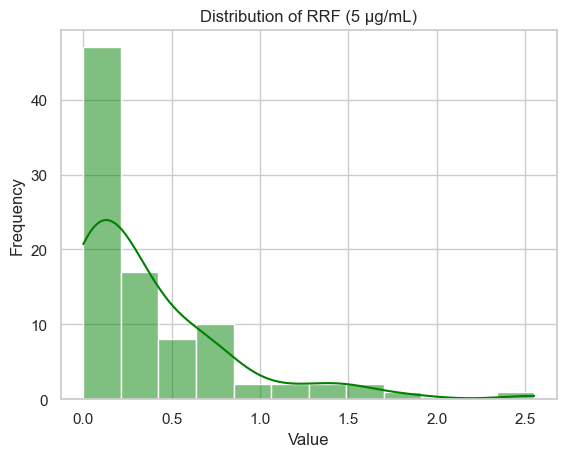

In [194]:
sns.histplot(df_final['5 µg/mL'], kde=True, color='green')
plt.title('Distribution of RRF (5 µg/mL)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

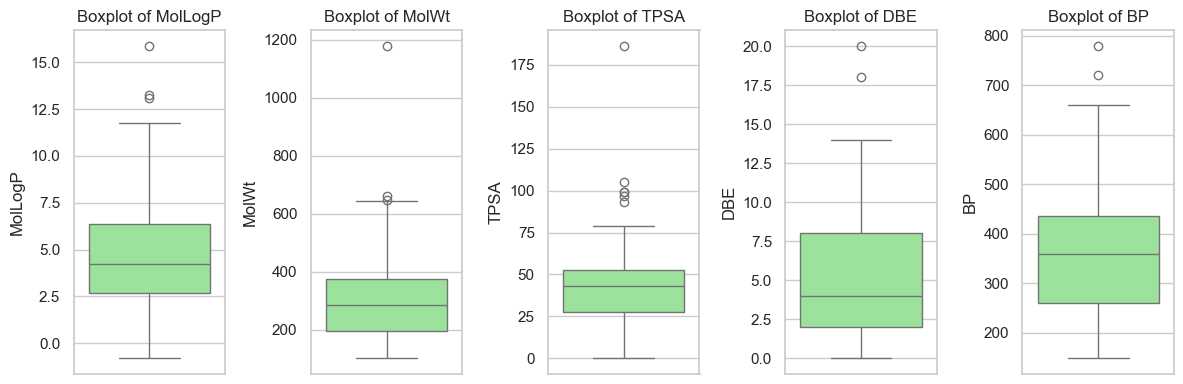

In [195]:
key_desc = ['MolLogP', 'MolWt', 'TPSA', 'DBE', 'BP']

plt.figure(figsize=(12, 4))
for i, col in enumerate(key_desc):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df_final[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

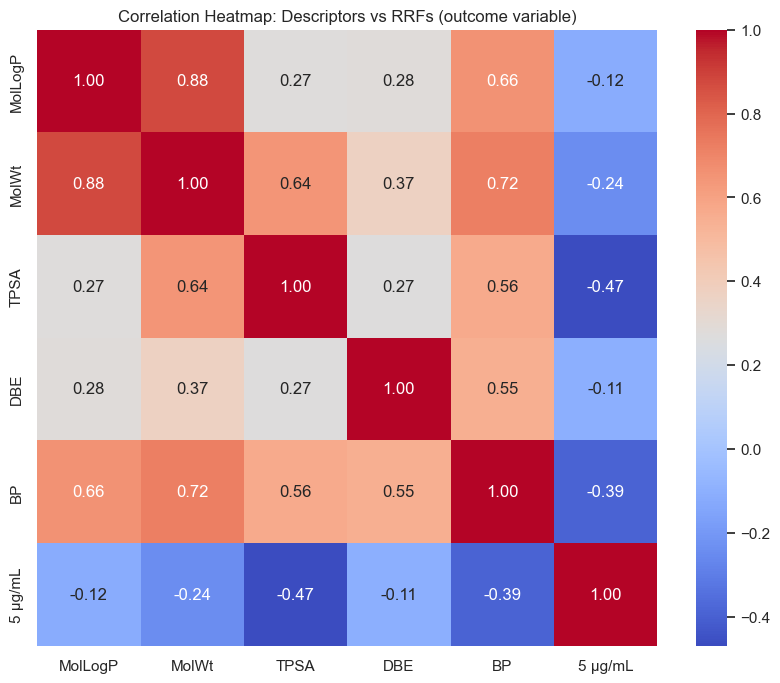

In [196]:
corr_matrix = df_final[key_desc + ['5 µg/mL']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Descriptors vs RRFs (outcome variable)')
plt.show()

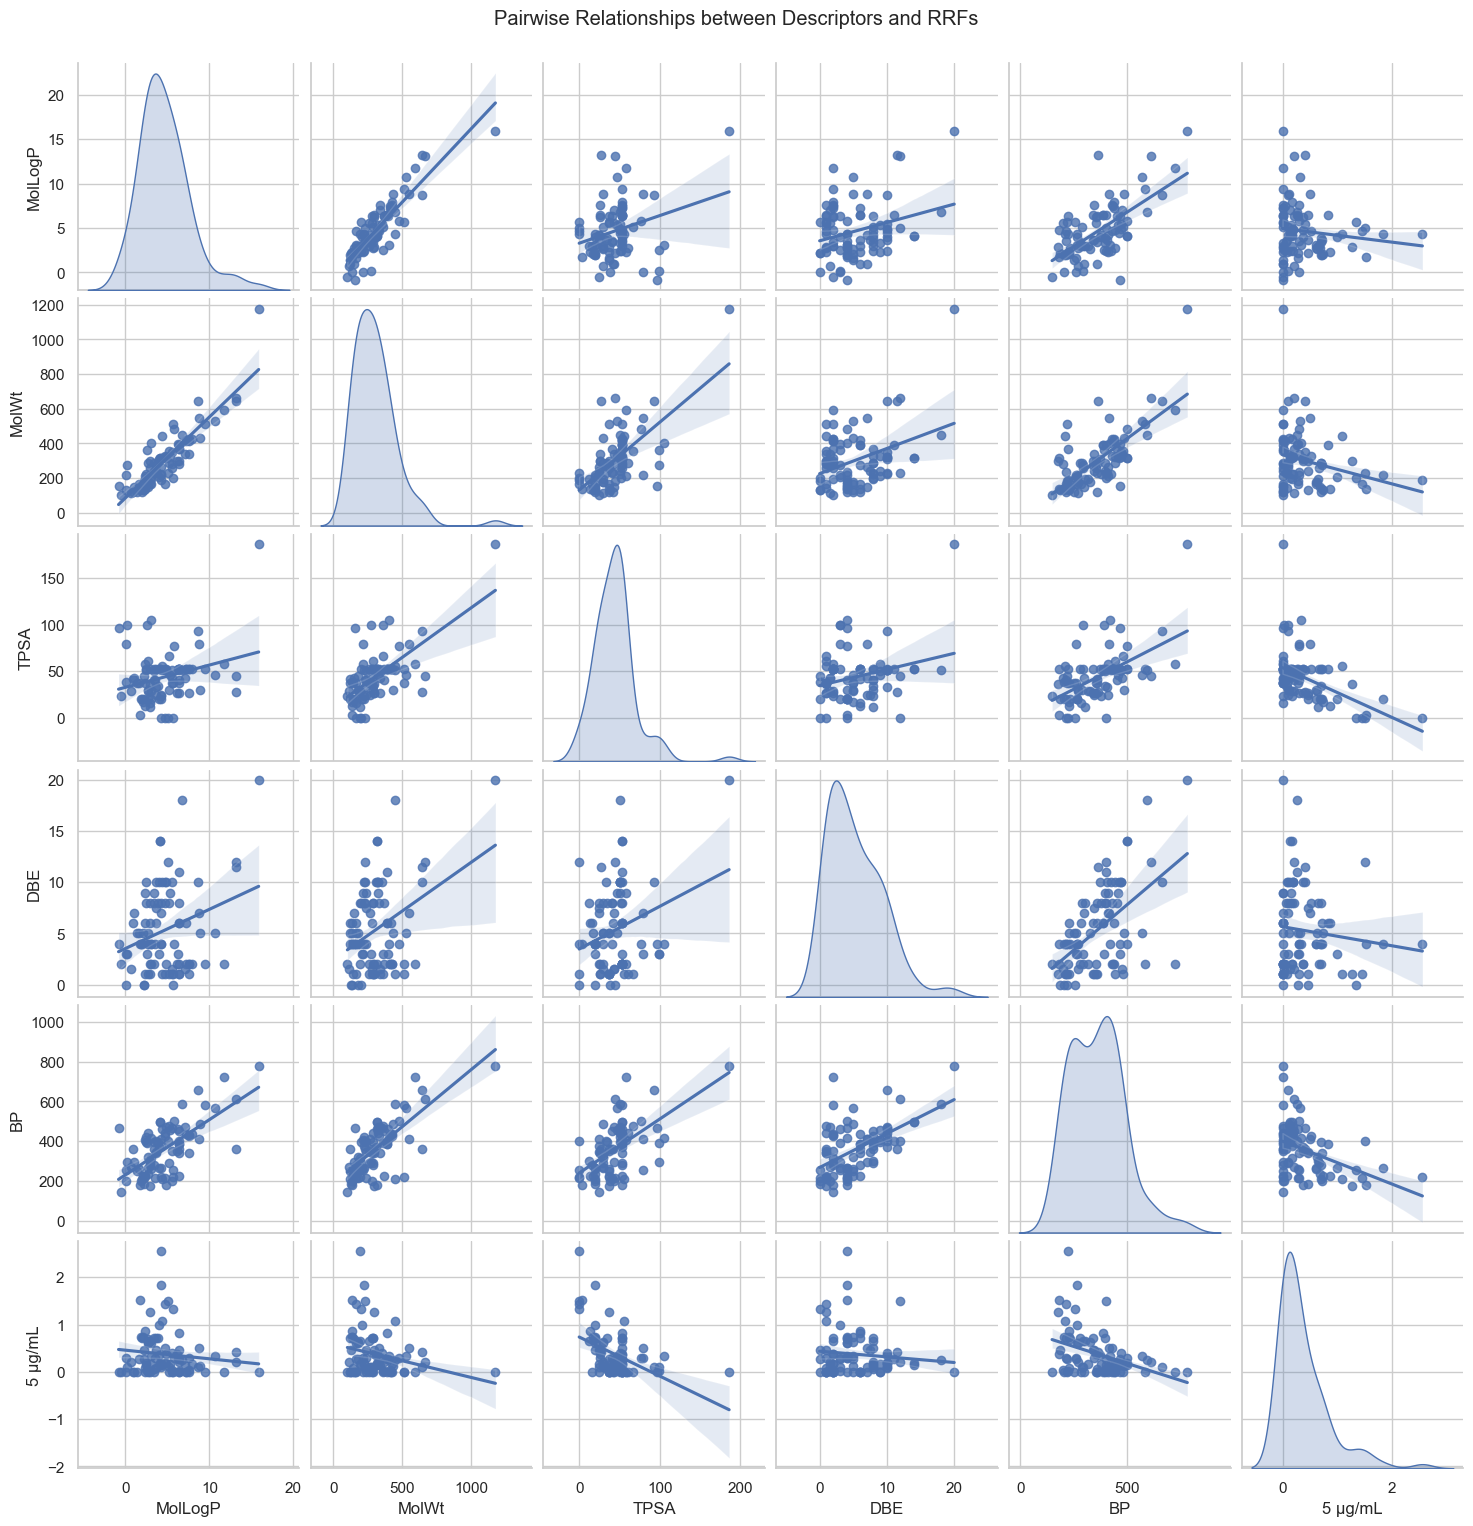

In [197]:
sns.pairplot(df_final, vars=['MolLogP', 'MolWt', 'TPSA', 'DBE', 'BP', '5 µg/mL'], kind='reg', diag_kind='kde')
plt.suptitle('Pairwise Relationships between Descriptors and RRFs', y=1.02)
plt.show()

### Multiple imputation for missing values

I selected relevant descriptors in addition to the ones provided by the CLAP list. Another version exist with all predictors.

In [198]:
missing_data = df_final.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

print(missing_data)


pKa                 27
Refractive Index     3
BP                   1
dtype: int64


Missing values exist for `pKA` (27),  `Refractive Index`(3), `BP`(1).
Values for RI and BP will be imputed using Multiple Imputation. pKA will not be used in the models.

In [199]:
X = df_final.drop(['5 µg/mL', 'IUPAC name', 'CAS #', 'Empirical Formula', '10 µg/mL', '20 µg/mL', 'Code', 'pKa', 'SMILES', 'BP', 'logP', 'DBE', 'MW', 'Refractive Index'] , axis=1) # Features without the 5 µg/mL RRF
y = df_final['5 µg/mL'] # outcome

# Multiple Imputation using IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=42)
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Impute and Scale (for Elastic Net and SVM)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Keep as DataFrames for feature selection reference
feature_names = X.columns
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)


X_train_sel = X_train_df
X_test_sel = X_test_df

## 5. Model Selection

As we have a continuous outcome: we will fit three models : \\
Elastic regression (parametric) \\
Random Forests (non-parametric)  \\
Support Vector Machines (non-parametric) \\


## 6. Model training

### ELastic Net Regression

In [200]:
enet = ElasticNet(random_state=42)
enet.fit(X_train_sel, y_train)

,alpha,1.0
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


### Random Forest

In [201]:
RF_model = RandomForestRegressor(n_estimators=100,
                   random_state=42, n_jobs=-1)
RF_model.fit(X_train_sel, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Gradient Boosting (LGBM)

In [202]:
LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train_sel, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Support Vector Machine

In [203]:
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_sel, y_train)


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [204]:
models = {
    'ElasticNet': enet,
    'Random Forest': RF_model,
    'Gradient Boosting (LGBM)': LGBM_model,
    'SVM': svm_model
}

## 7. Model Evaluation

In [205]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def evaluate_model_cv(model, X, y, model_name="Model"):
    cv_predictions = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    
    cv_r2 = r2_score(y, cv_predictions)
    cv_mae = mean_absolute_error(y, cv_predictions)
    cv_rmse = np.sqrt(mean_squared_error(y, cv_predictions))
    
    print(f"--- {model_name} (k-Fold CV) ---")
    print(f"R²:   {cv_r2:.4f}")
    print(f"MAE:  {cv_mae:.4f}")
    print(f"RMSE: {cv_rmse:.4f}\n")
    
    return cv_predictions

cv_results = {}
for name, model in models.items():
    cv_results[name] = evaluate_model_cv(model, X_train_sel, y_train, name)

--- ElasticNet (k-Fold CV) ---
R²:   -0.0139
MAE:  0.3340
RMSE: 0.4691

--- Random Forest (k-Fold CV) ---
R²:   0.3614
MAE:  0.2686
RMSE: 0.3723

--- Gradient Boosting (LGBM) (k-Fold CV) ---
R²:   0.2392
MAE:  0.2973
RMSE: 0.4064

--- SVM (k-Fold CV) ---
R²:   0.4333
MAE:  0.2425
RMSE: 0.3507



## 8. Model optimisation for Random Forest and SVM

Elastic Regression was already optimised during the feature engineering. Therefore, we focus the hyperparameter tuning for RF and SVM.

The strategy is to use a Bayesian optimization (Optuna), to ensure that all parameters will optimise the objective function (maximizing R²)

In [206]:
def objective_svm(trial):
    c = trial.suggest_float('C', 1e-3, 1e2, log=True)
    epsilon = trial.suggest_float('epsilon', 1e-3, 0.5, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    model = SVR(C=c, epsilon=epsilon, gamma=gamma)
    
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2').mean()
    return score

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=30)

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

def objective_lgbm(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMRegressor(**param)
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2').mean()
    return score

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=50)

[I 2026-01-13 10:24:16,205] A new study created in memory with name: no-name-7cf53e89-a926-4792-9ad2-5f0743bbe3ce
[I 2026-01-13 10:24:16,246] Trial 0 finished with value: -0.12341733588077056 and parameters: {'C': 0.0021238054558181483, 'epsilon': 0.001833063252087498, 'gamma': 'auto'}. Best is trial 0 with value: -0.12341733588077056.
[I 2026-01-13 10:24:16,277] Trial 1 finished with value: -0.0054841504253642535 and parameters: {'C': 0.047366107155297585, 'epsilon': 0.05206291845888399, 'gamma': 'auto'}. Best is trial 1 with value: -0.0054841504253642535.
[I 2026-01-13 10:24:16,308] Trial 2 finished with value: -0.13647442381346755 and parameters: {'C': 0.0025452946324204862, 'epsilon': 0.041904372876920226, 'gamma': 'scale'}. Best is trial 1 with value: -0.0054841504253642535.
[I 2026-01-13 10:24:16,341] Trial 3 finished with value: 0.42664148252640566 and parameters: {'C': 2.3023361122586103, 'epsilon': 0.028475230806771903, 'gamma': 'scale'}. Best is trial 3 with value: 0.42664148

In [207]:
optuna.visualization.plot_optimization_history(study_svm)

In [208]:
optuna.visualization.plot_param_importances(study_svm)


In [209]:
optuna.visualization.plot_optimization_history(study_rf)

In [210]:
optuna.visualization.plot_param_importances(study_rf)

In [211]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [212]:
def plot_model_performance(y_true, y_pred, model_name):
    """
    Generates Predicted vs Actual and Residuals plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Predicted vs Actual
    
    axes[0].scatter(y_true, y_pred, alpha=0.6, color='blue', edgecolor='k')
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    axes[0].set_title(f'{model_name}: Predicted vs Actual')
    axes[0].set_xlabel('Actual RRF')
    axes[0].set_ylabel('Predicted RRF')
    axes[0].grid(True)

    # Plot 2: Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, color='purple', edgecolor='k')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    
    axes[1].set_title(f'{model_name}: Residual Plot')
    axes[1].set_xlabel('Predicted RRF')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

### Model evaluation on the Optimized Models

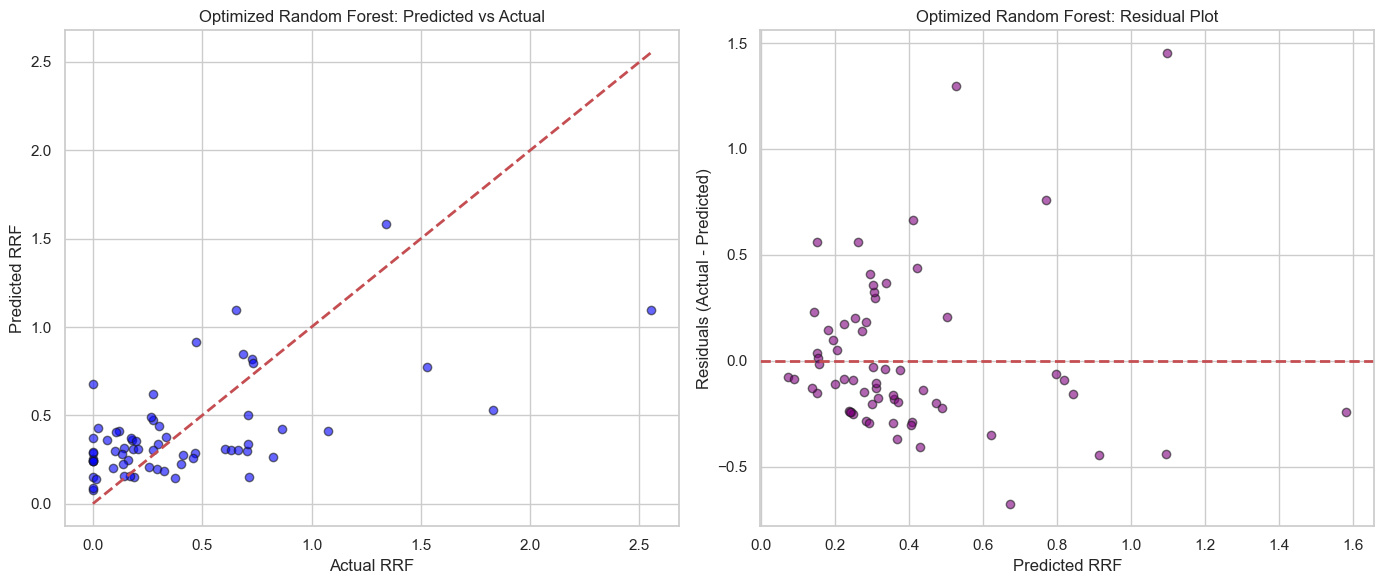

--- Final Optimized RF Metrics ---
CV R²: 0.3555
CV RMSE: 0.3740
--- PERFORMANCE ON HOLD-OUT TEST SET ---
Test R²:   0.7040
Test RMSE: 0.2425


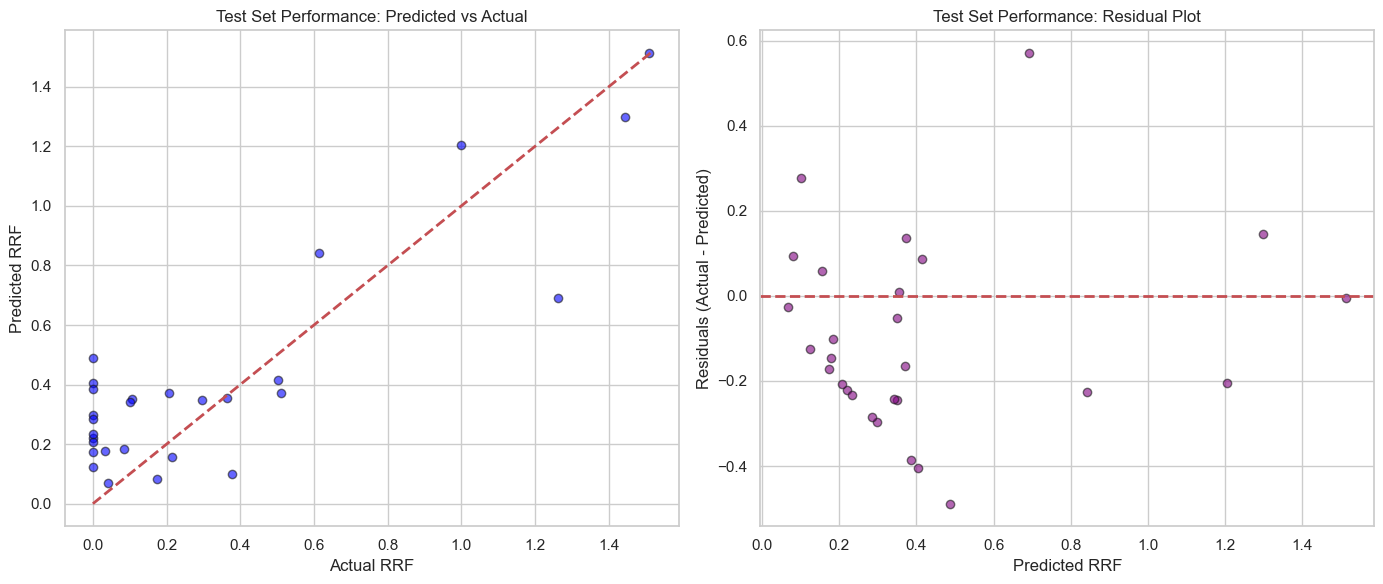

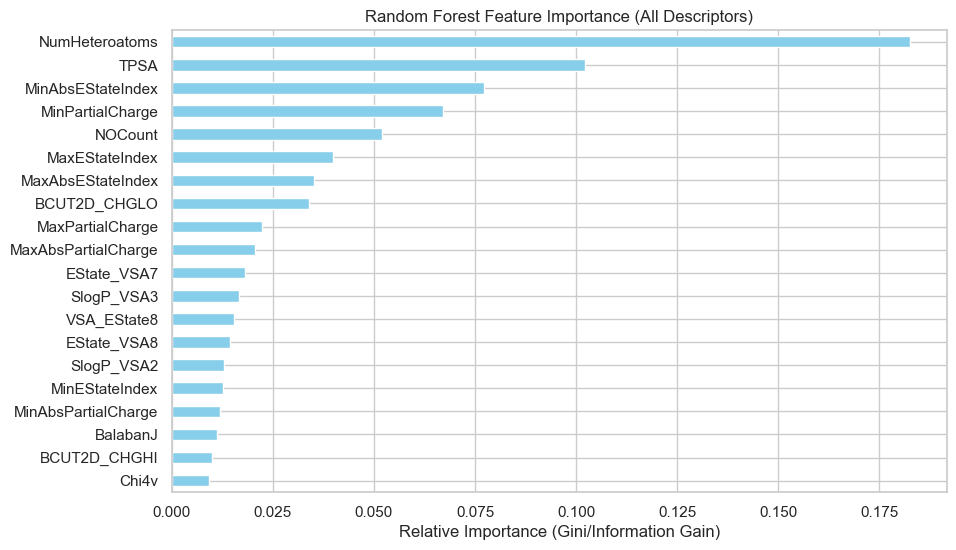

In [213]:
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)

best_rf.fit(X_train_sel, y_train)

cv_preds_final = cross_val_predict(best_rf, X_train_sel, y_train, cv=kf, n_jobs=-1)

plot_model_performance(y_train, cv_preds_final, "Optimized Random Forest")

print("--- Final Optimized RF Metrics ---")
print(f"CV R²: {r2_score(y_train, cv_preds_final):.4f}")
print(f"CV RMSE: {np.sqrt(mean_squared_error(y_train, cv_preds_final)):.4f}")

test_predictions = best_rf.predict(X_test_sel)

print("--- PERFORMANCE ON HOLD-OUT TEST SET ---")
print(f"Test R²:   {r2_score(y_test, test_predictions):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

# Optional: Visualize Test Set performance
plot_model_performance(y_test, test_predictions, "Test Set Performance")

importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train_sel.columns)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importance (All Descriptors)')
plt.xlabel('Relative Importance (Gini/Information Gain)')
plt.show()

#selected_features = feat_importances.nlargest(20).index.tolist()
#print(selected_features)

# Best LGBM

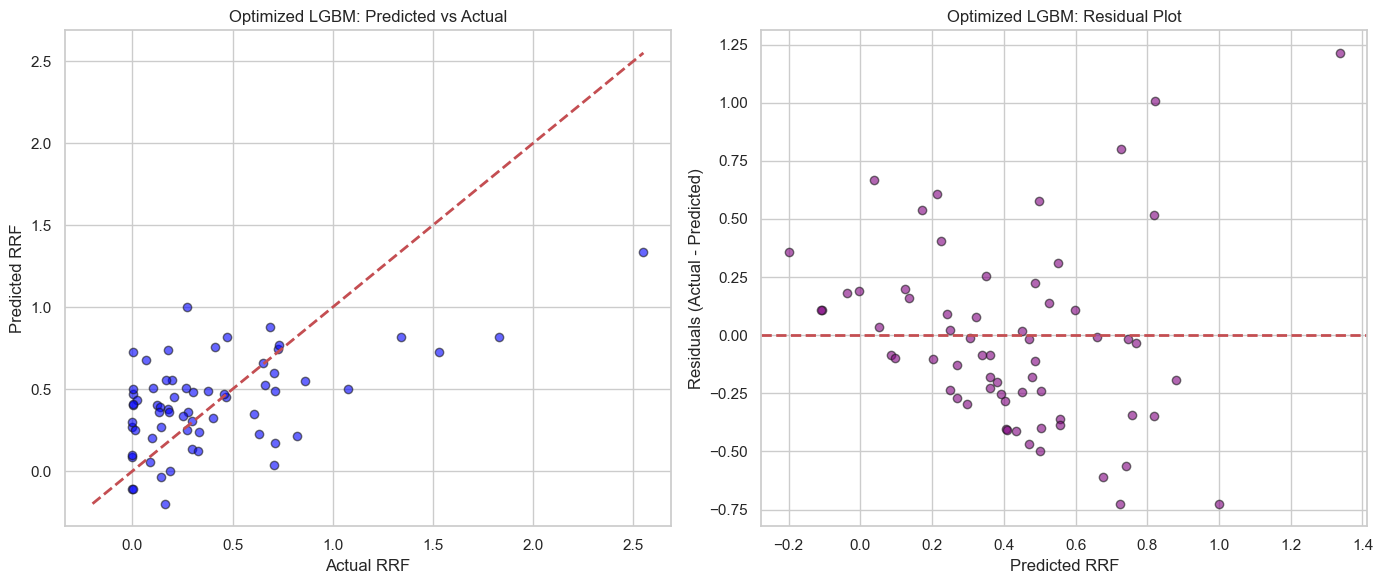

--- Final Optimized RF Metrics ---
CV R²: 0.3028
CV RMSE: 0.3890
--- PERFORMANCE ON HOLD-OUT TEST SET ---
Test R²:   0.6648
Test RMSE: 0.2580


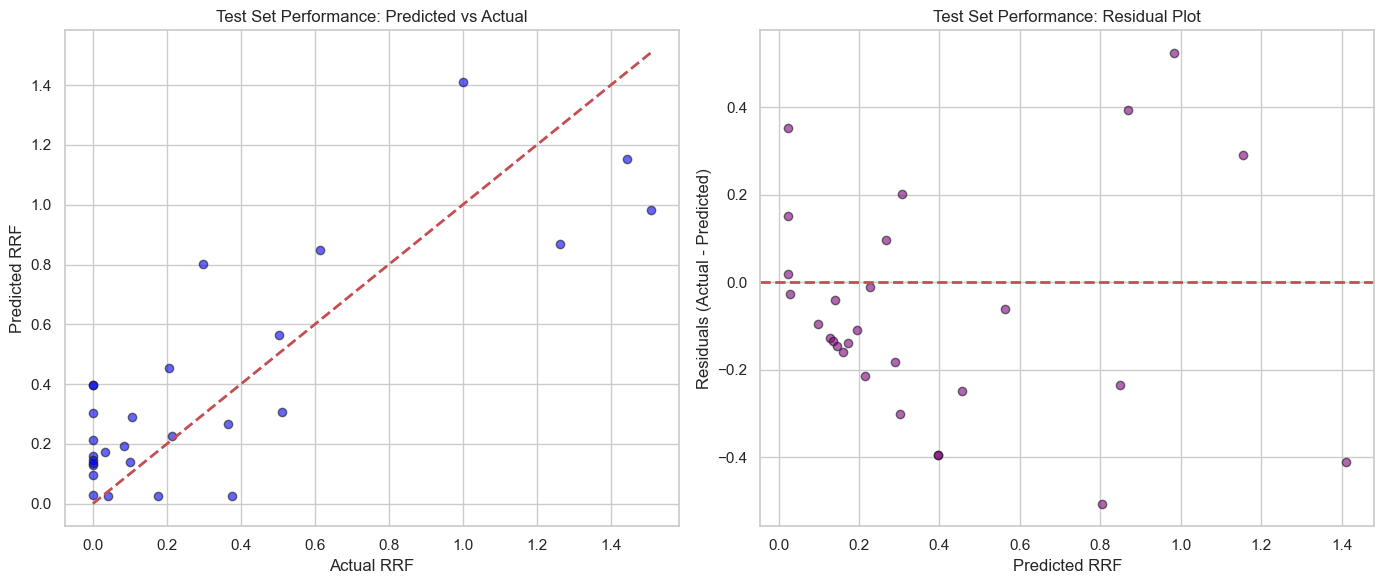

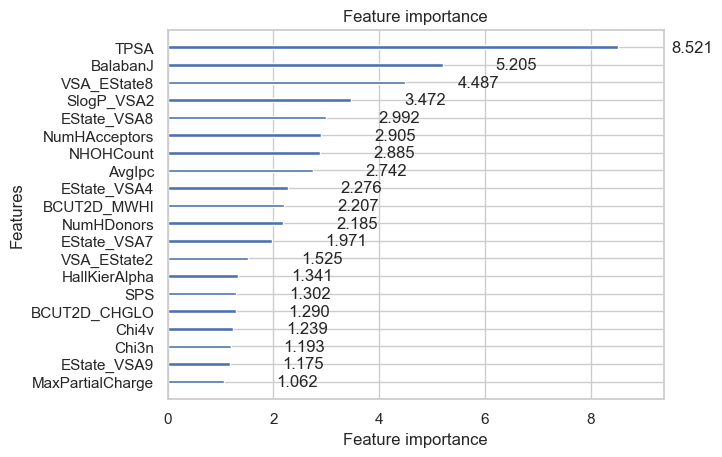

['TPSA', 'BalabanJ', 'VSA_EState8', 'SlogP_VSA2', 'EState_VSA8', 'NumHAcceptors', 'NHOHCount', 'AvgIpc', 'EState_VSA4', 'BCUT2D_MWHI', 'NumHDonors', 'EState_VSA7', 'VSA_EState2', 'HallKierAlpha', 'SPS', 'BCUT2D_CHGLO', 'Chi4v', 'Chi3n', 'EState_VSA9', 'MaxPartialCharge']


In [214]:
import lightgbm as lgb

best_LGBM = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)

best_LGBM.fit(X_train_sel, y_train)

cv_preds_final = cross_val_predict(best_LGBM, X_train_sel, y_train, cv=kf, n_jobs=-1)

plot_model_performance(y_train, cv_preds_final, "Optimized LGBM")

print("--- Final Optimized RF Metrics ---")
print(f"CV R²: {r2_score(y_train, cv_preds_final):.4f}")
print(f"CV RMSE: {np.sqrt(mean_squared_error(y_train, cv_preds_final)):.4f}")

test_predictions = best_LGBM.predict(X_test_sel)

print("--- PERFORMANCE ON HOLD-OUT TEST SET ---")
print(f"Test R²:   {r2_score(y_test, test_predictions):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

# Optional: Visualize Test Set performance
plot_model_performance(y_test, test_predictions, "Test Set Performance")

lgb.plot_importance(best_LGBM, max_num_features=20, importance_type='gain')
plt.show()

importances = best_LGBM.booster_.feature_importance(importance_type='gain')
feature_names = X_train_sel.columns
lgbm_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

lgbm_selected_features = lgbm_feat_importance.head(20)['feature'].tolist()
print(lgbm_selected_features)

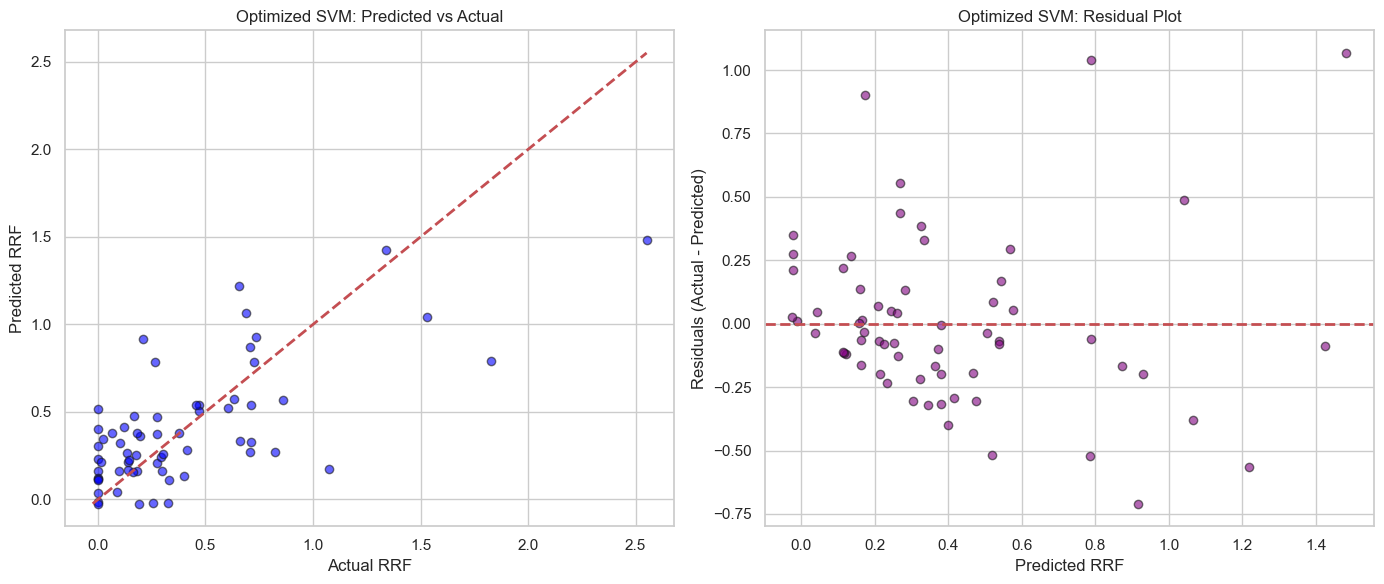

--- Final Optimized RF Metrics ---
CV R²: 0.4845
CV RMSE: 0.3345
--- PERFORMANCE ON HOLD-OUT TEST SET ---
Test R²:   0.6713
Test RMSE: 0.2555


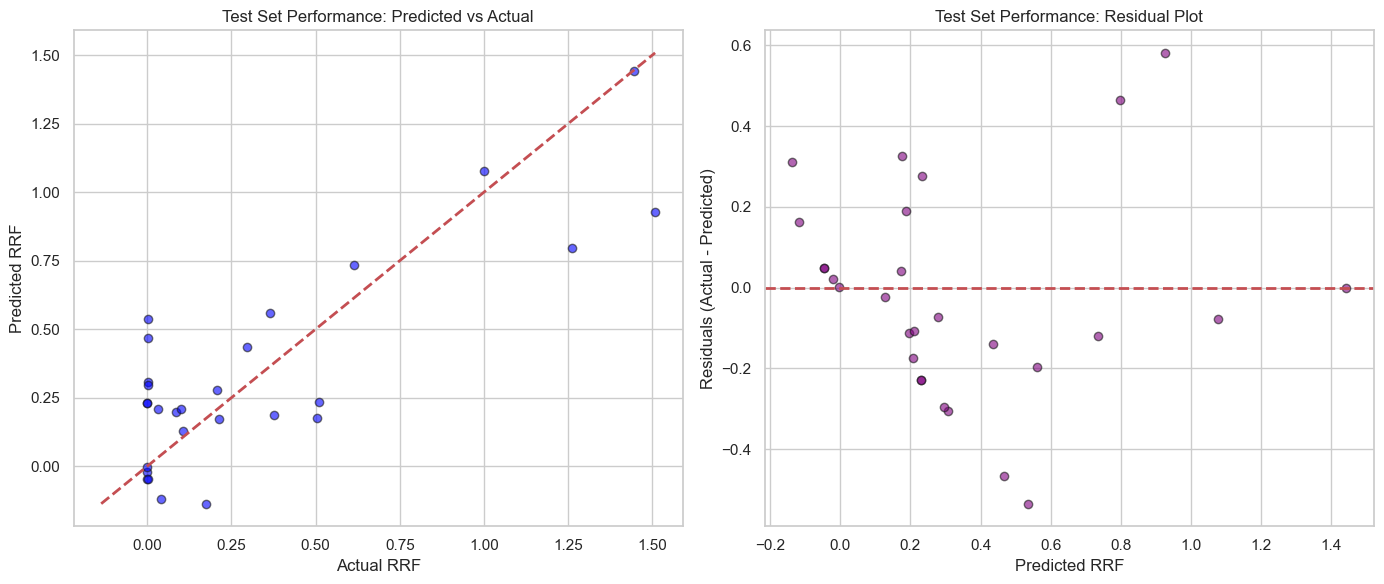

In [215]:
best_svm = SVR(**study_svm.best_params)
               
best_svm.fit(X_train_sel, y_train)

cv_preds_final = cross_val_predict(best_svm, X_train_sel, y_train, cv=kf, n_jobs=-1)

plot_model_performance(y_train, cv_preds_final, "Optimized SVM")

print("--- Final Optimized RF Metrics ---")
print(f"CV R²: {r2_score(y_train, cv_preds_final):.4f}")
print(f"CV RMSE: {np.sqrt(mean_squared_error(y_train, cv_preds_final)):.4f}")

test_predictions = best_svm.predict(X_test_sel)

print("--- PERFORMANCE ON HOLD-OUT TEST SET ---")
print(f"Test R²:   {r2_score(y_test, test_predictions):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

# Optional: Visualize Test Set performance
plot_model_performance(y_test, test_predictions, "Test Set Performance")

## Save the model & the final dataset 

In [216]:
import joblib

X_train_final = X_train_df
X_test_final = X_test_df

best_svm = SVR(**study_svm.best_params)
               
best_svm.fit(X_train_sel, y_train)

joblib.dump(best_svm, 'rf_rrf_model_final_20.joblib')
#joblib.dump(selected_features, 'features_20.joblib')

['rf_rrf_model_final_20.joblib']

In [217]:
df_final.to_csv("final_model_data.csv", index=False)

# External Validation

In [ ]:
df2 = pd.read_excel('processed_data/ZdravkovicRRF.xlsx')

In [219]:
df2['SMILES'] = df2['CAS'].apply(get_smiles_from_cas)

In [220]:
df2['SMILES'].apply(standardize_and_describe)
df2_final = df2.join(df2['SMILES'].apply(standardize_and_describe).apply(pd.Series))

In [221]:
loaded_model = joblib.load('rf_rrf_model_final_20.joblib')
saved_features = joblib.load('features_20.joblib')

In [222]:
X_val = df2_final.drop(['RRF', 1, 2, 3, 4, 'average', 'CAS', 'Name', 'SMILES'],  axis=1)
y_val = df2_final['RRF']

--- EXTERNAL VALIDATION RESULTS (df2) ---
R²:   -6.8615
RMSE: 1.1336
MAE:  1.0590


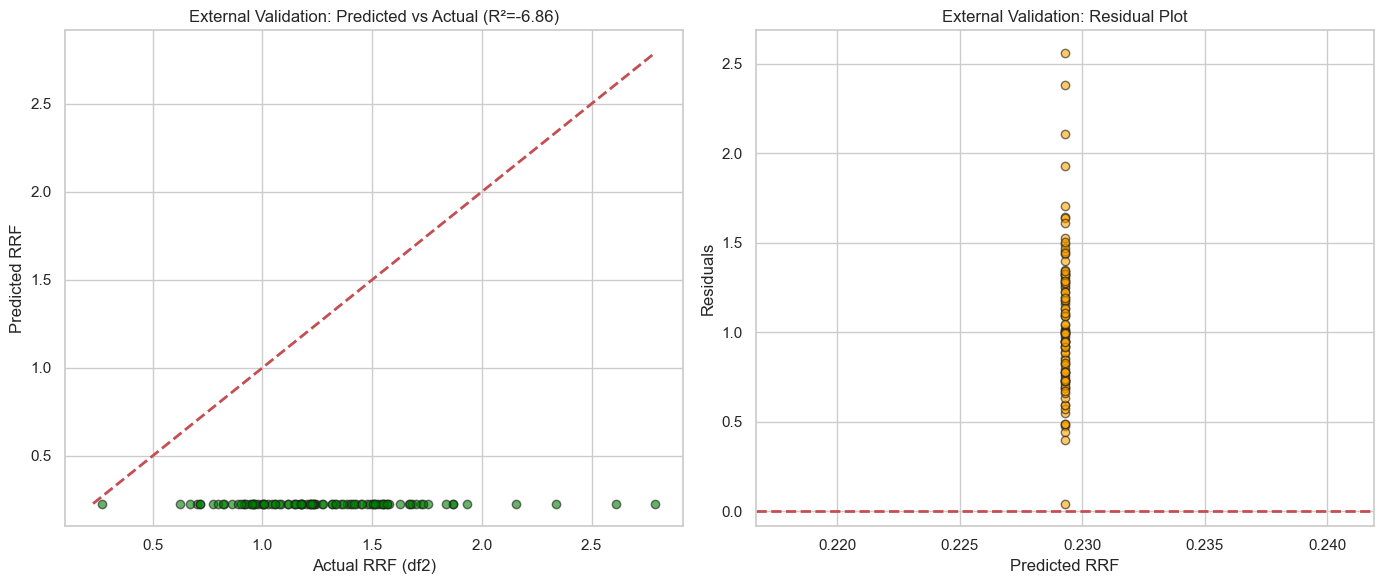

In [223]:
y_val_pred = loaded_model.predict(X_val)

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)

print("--- EXTERNAL VALIDATION RESULTS (df2) ---")
print(f"R²:   {r2_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE:  {mae_val:.4f}")

def plot_external_validation(y_true, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Predicted vs Actual
    axes[0].scatter(y_true, y_pred, alpha=0.6, color='green', edgecolor='k')
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[0].set_title(f'External Validation: Predicted vs Actual (R²={r2_val:.2f})')
    axes[0].set_xlabel('Actual RRF (df2)')
    axes[0].set_ylabel('Predicted RRF')
    axes[0].grid(True)

    # Plot 2: Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, color='orange', edgecolor='k')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_title('External Validation: Residual Plot')
    axes[1].set_xlabel('Predicted RRF')
    axes[1].set_ylabel('Residuals')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_external_validation(y_val, y_val_pred)

In [224]:
df2_final.to_csv("val_data.csv", index=False)

In [225]:
# Create a dataframe of errors
df_results = pd.DataFrame({
    'CAS': df2_final['CAS'],
    'SMILES': df2_final['SMILES'], # Assuming SMILES are in df2_final
    'Actual': y_val,
    'Predicted': y_val_pred
})
df_results['Error'] = df_results['Predicted'] - df_results['Actual'] 

# Show the top 5 worst predictions
print(df_results.sort_values('Error', ascending=False).head(5))

           CAS                                             SMILES   Actual  \
95   2082-79-3  CCCCCCCCCCCCCCCCCCOC(=O)CCC1=CC(=C(C(=C1)C(C)(...  0.27150   
82  82304-66-3         CC(C)(C)C1=CC2(CCC(=O)O2)C=C(C1=O)C(C)(C)C  0.62525   
3      66-25-1                                           CCCCCC=O  0.67025   
2     591-78-6                                         CCCCC(=O)C  0.70275   
75   211-946-0                 CC(C)(C)C1=CC(=O)C=C(C1=O)C(C)(C)C  0.71675   

    Predicted     Error  
95   0.229288 -0.042212  
82   0.229288 -0.395962  
3    0.229288 -0.440962  
2    0.229288 -0.473462  
75   0.229288 -0.487462  
